In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn import datasets
import matplotlib.pyplot as plt

In [47]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor):
        x = self.input_to_hidden(x)
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_to_output(x)
        return x

In [48]:
X, y = datasets.make_regression(n_samples=1000, n_features=1, noise=5, random_state=4)

y = y.reshape(-1, 1)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

In [49]:
class Data(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        # need to convert float64 to float32 else
        # will get the following error
        # RuntimeError: expected scalar type Double but found Float
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index: int) -> tuple:
        return self.X[index], self.y[index]

    def __len__(self) -> int:
        return self.len


In [50]:
traindata = Data(X_train, y_train)
batch_size = 64
num_workers = 2
trainloader = DataLoader(traindata,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers)

In [51]:
input_dim = X_train.shape[1]
hidden_layers = 50
output_dim = 1
model = LinearRegression(input_dim, hidden_layers, output_dim)
model

LinearRegression(
  (input_to_hidden): Linear(in_features=1, out_features=50, bias=True)
  (hidden_layer_1): Linear(in_features=50, out_features=50, bias=True)
  (hidden_layer_2): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=1, bias=True)
)

In [52]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [53]:
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #inputs, labels = traindata
        # forward propagation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # set optimizer to zero grad
        # to remove previous epoch gradients
        optimizer.zero_grad()
        # backward propagation
        loss.backward()
        # optimize
        optimizer.step()
        running_loss += loss.item()
    # display statistics
    if not ((epoch + 1) % (epochs // 10)):
        print(f'Epochs:{epoch + 1:5d} | ' \
              f'Batches per epoch: {i + 1:3d} | ' \
              f'Loss: {running_loss / (i + 1):.10f}')


Epochs:  100 | Batches per epoch:  11 | Loss: 0.0009107637
Epochs:  200 | Batches per epoch:  11 | Loss: 0.0008453405
Epochs:  300 | Batches per epoch:  11 | Loss: 0.0008924424
Epochs:  400 | Batches per epoch:  11 | Loss: 0.0008284759
Epochs:  500 | Batches per epoch:  11 | Loss: 0.0010366843
Epochs:  600 | Batches per epoch:  11 | Loss: 0.0008685316
Epochs:  700 | Batches per epoch:  11 | Loss: 0.0008271387
Epochs:  800 | Batches per epoch:  11 | Loss: 0.0008163520
Epochs:  900 | Batches per epoch:  11 | Loss: 0.0008819858
Epochs: 1000 | Batches per epoch:  11 | Loss: 0.0008539091


In [54]:
testdata = Data(X_test, y_test)
testloader = DataLoader(testdata, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

ValueError: x and y must have same first dimension, but have shapes (1000, 1) and torch.Size([64, 1])

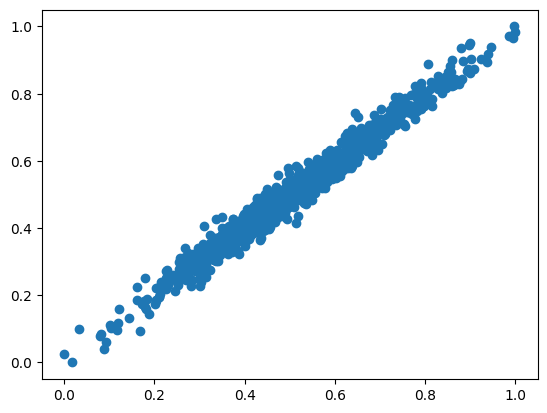

In [59]:
with torch.no_grad():
    plt.scatter(X_scaled, y_scaled, label='Original data')
    loss = 0
    for i, (inputs, labels) in enumerate(testloader):
        predictions = model(inputs)
        labels = torch.from_numpy(y_scaler.inverse_transform(labels))
        predictions = torch.from_numpy(y_scaler.inverse_transform(predictions))
        loss += F.mse_loss(predictions, labels)
        plt.plot(X_scaled, predictions, 'r-', label='Fitted line')
    
    plt.legend()
    plt.show()
        
    print(f'MSE Loss: {loss / (i + 1):.5f}')

In [56]:
# save the trained model
PATH = './lin_reg_model.pth'
torch.save(model.state_dict(), PATH)

In [57]:
model1 = LinearRegression(input_dim, hidden_layers, output_dim)
model1.load_state_dict(torch.load(PATH))

<All keys matched successfully>